<a href="https://colab.research.google.com/github/SkyGuy312/face-pose-detection/blob/main/FacePoseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing mediapipe package

In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 244 kB/s 


# Importing Needed Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
from sklearn.model_selection import cross_val_score,GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow


##### Warnings are sometimes annoying so we will ignore them

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

### Load the dataset into colab workspace

In [4]:
%%capture
                                                                                # check if zip file is in workspace - if it already exists then there's no need to capture the data
if not os.path.isfile('/content/AFLW2000-3D.zip'):
  !gdown --id 1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap                                 # download the data using its id
  !unzip /content/AFLW2000-3D.zip                                               # unzip it into its own folder

### Create needed variables

In [5]:
all_X_landmarks = []                                                            # horizontal feature components to be extracted from images
all_Y_landmarks = []                                                            # vertical feature components to be extracted from images
labels = []                                                                     # pitch, yaw and roll values for each image
detected_files = []                                                             # files available in data folder
file_names = sorted(                                                            # extracting the file names
    [Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")]
    )

### Extracting points from images using mediapipe's facemesh detector

##### Performing Extraction Process

In [6]:
faceModule = mediapipe.solutions.face_mesh                                      # facial mesh extractor

for filename in file_names:                                                     # iterate on each file name, do the following
  with faceModule.FaceMesh(static_image_mode=True) as raw_data:                 # create a FaceMesh object for the current fileName, no video stream allowed
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')                    # load image using file name into memory
    results = raw_data.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))          # generate landmarks from the loaded image
    
    if results.multi_face_landmarks != None:                                    # making sure image is actually a facial image not a bad sample
          detected_files.append(filename)                                       # save file names which do have raw_data
          face = results.multi_face_landmarks[0]                                # selecting face from generated data

          X = []                                                                # list to temporarily save horizontal landmark points
          Y = []                                                                # list to temporarily save vertical landmark points

          for landmark in face.landmark:                                        # extracting every landmark point in the selected face data
              X.append(int(landmark.x * image.shape[1]))                        # upscaling the x landmark component to the original image size, then saving it into x landmarks vector
              Y.append(int(landmark.y * image.shape[0]))                        # upscaling the y landmark component to the original image size, then saving it into y landmarks vector
              
          X = np.array(X)                                                       # converting both lists to numpy arrays
          Y = np.array(Y)

          all_X_landmarks.append(X)                                             # appending the points of the a single image in the list of all images' points
          all_Y_landmarks.append(Y)

          lbl_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')          # loading the .mat file to extract the labels (pitch,yaw,roll)
          label = lbl_file["Pose_Para"][0][:3]                                  # select the needed values
          labels.append(label)                                                  # appending the 3 angels to labels list

##### Converting the data into numpy arrays

In [7]:
all_X_landmarks = np.array(all_X_landmarks)
all_Y_landmarks = np.array(all_Y_landmarks)
labels = np.array(labels)

##### finalizing transofrmations on raw data and creating viable, useful features

The face mesh looks as follows:


1HaOSpu_eDt7gYqt1Lh8CC78d9F6O_tCY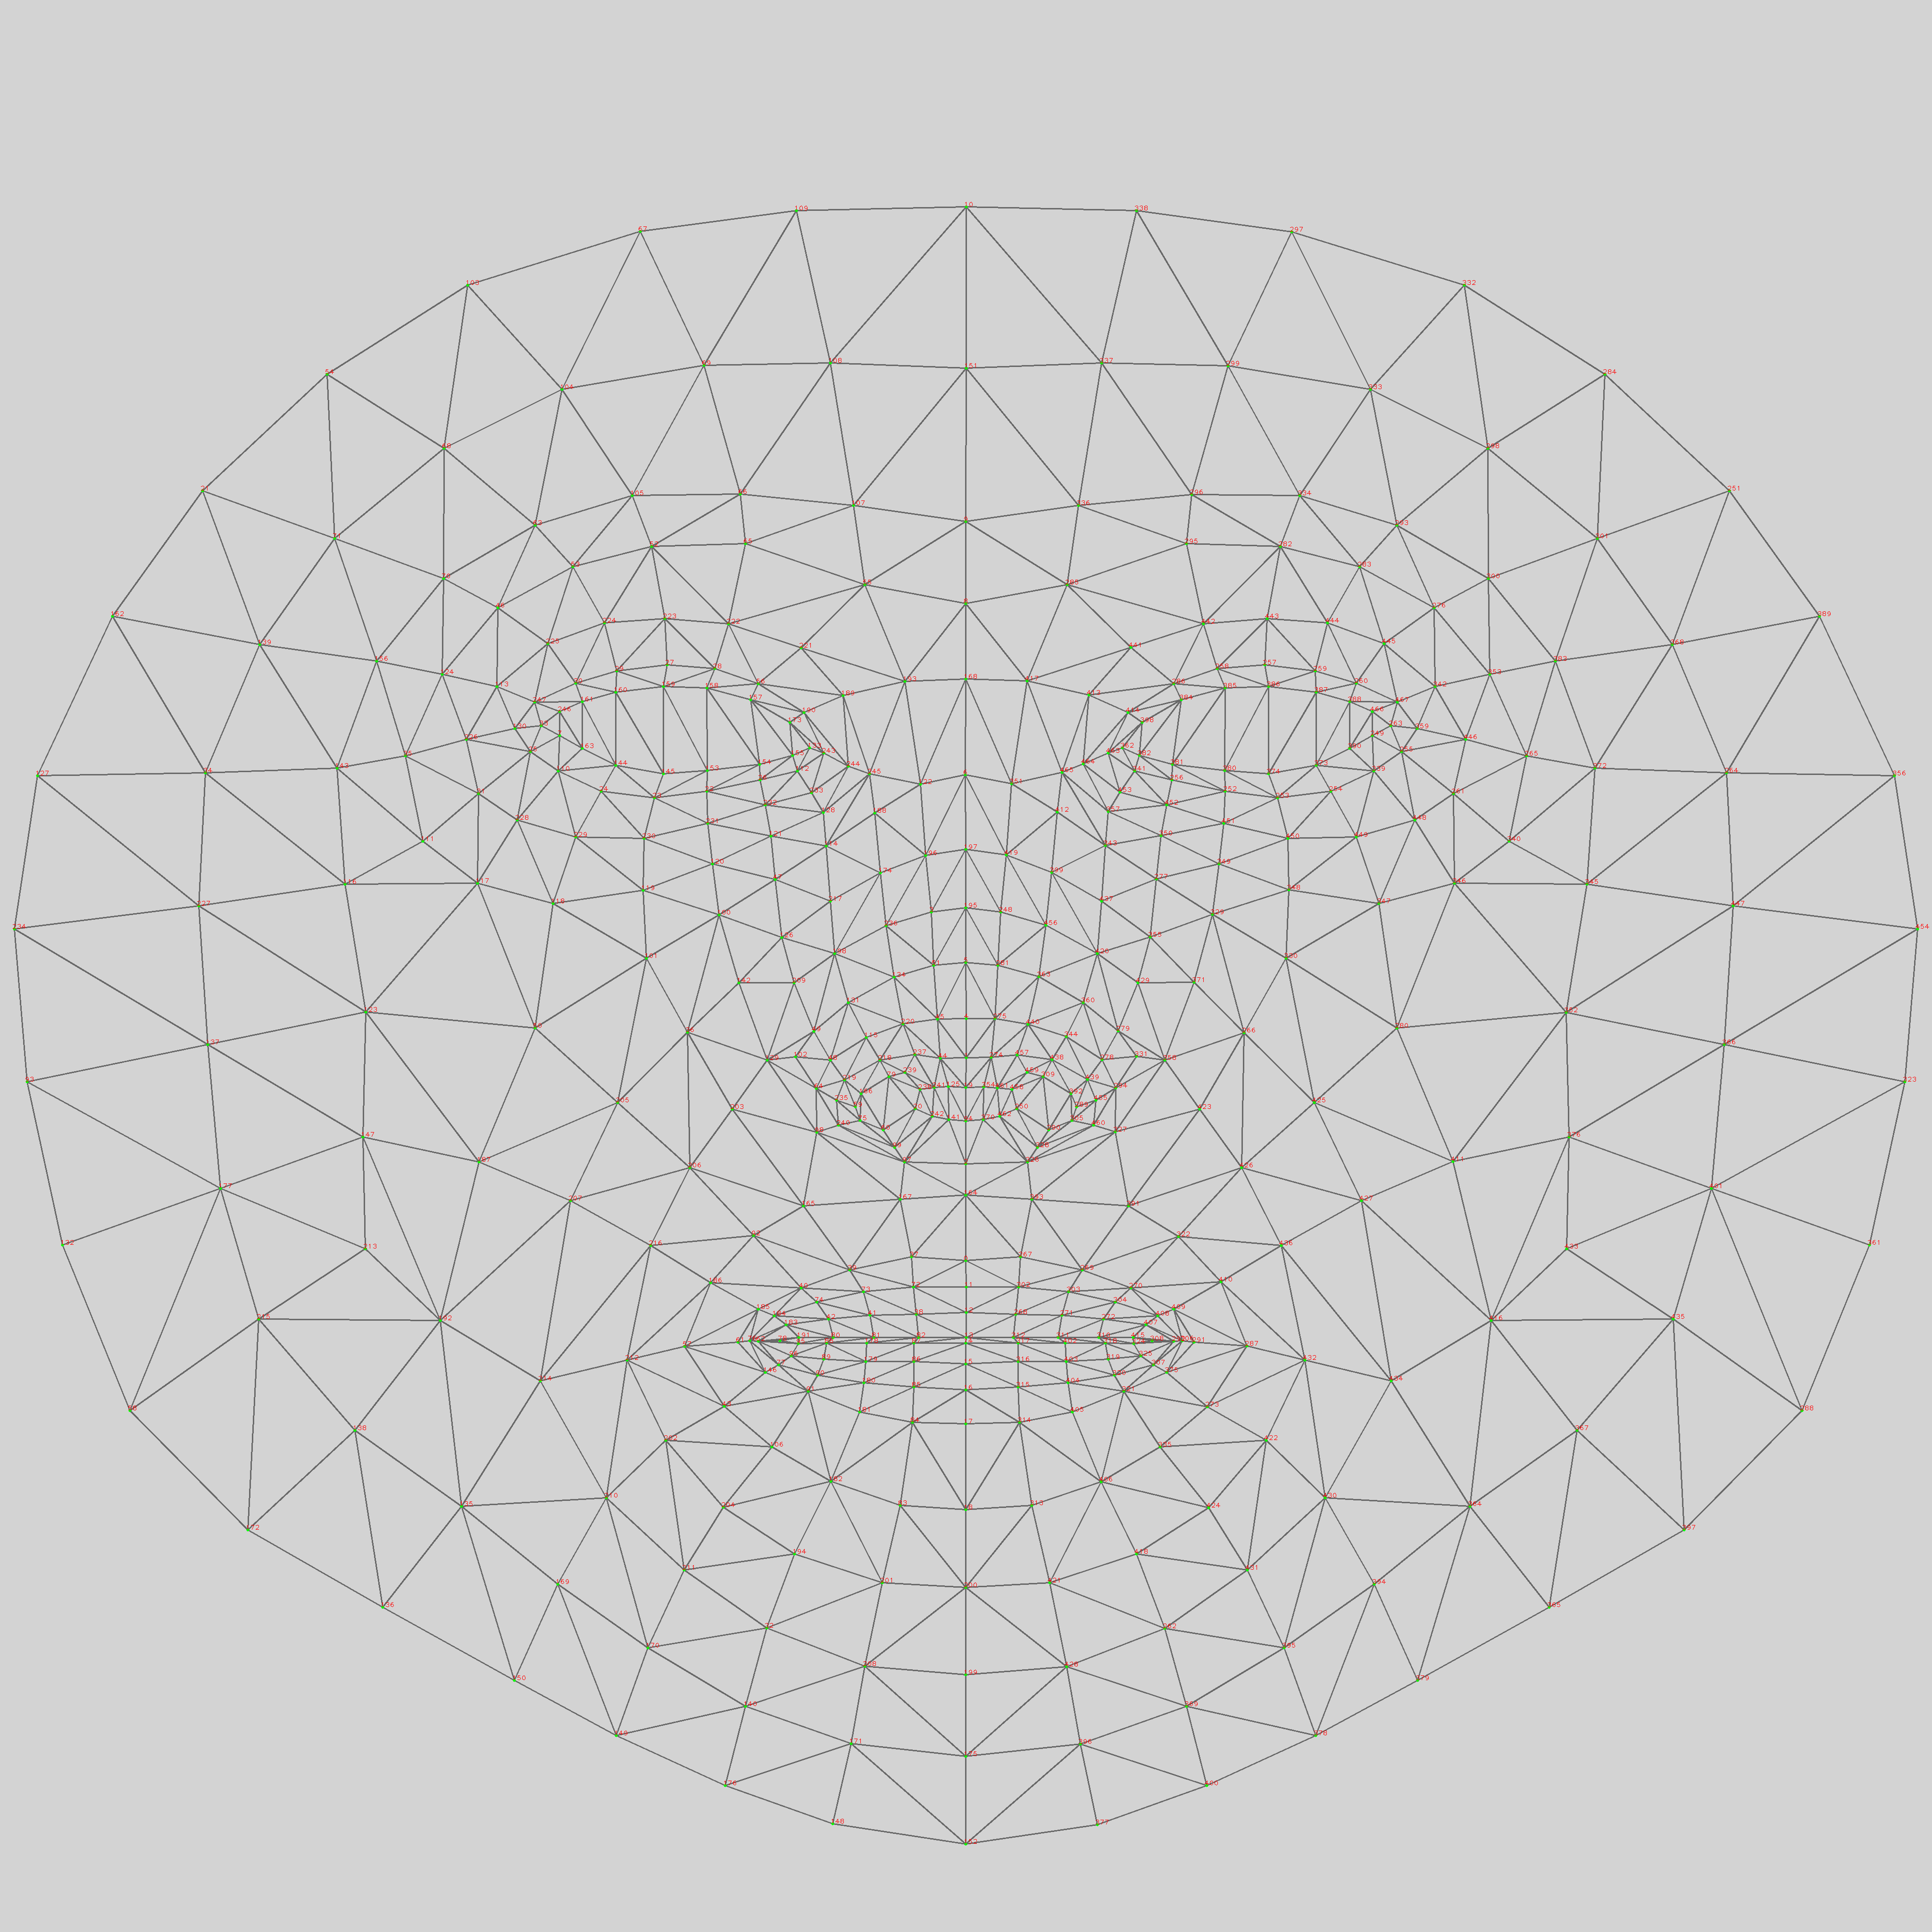

to have a more accurate representation of each point in data, we need to do the following:
* reference each point in each facemesh to a reference point **pereferbly if it is a point in the middle**.
* normalize **all** referenced data points to some arbitrary distance - which helps to make sense of relations between facial points.
* finally, create the **features** numpy array

for this project I chose:
* 2 for the *reference* point.
* 175, 10 for *arbitrary* normalize line.


##### Creating reference points

In [8]:
ref_X = all_X_landmarks - all_X_landmarks[:,2].reshape(-1,1)
ref_Y = all_Y_landmarks - all_Y_landmarks[:,2].reshape(-1,1)



##### Creating an arbitrary line

In [9]:
# Get points
X_175 = all_X_landmarks[:,175]
X_10 = all_X_landmarks[:,10]
Y_175 = all_Y_landmarks[:,175]
Y_10 = all_Y_landmarks[:,10]

# get line length
length = np.linalg.norm(
    np.array((X_10,Y_10)) - np.array((X_175,Y_175)),
    axis = 0
        ).reshape(-1,1)

##### Normalize the data points

In [10]:
ref_X = ref_X / length
ref_Y = ref_Y / length

##### Creating the features array

In [11]:
features = np.hstack([ref_X,ref_Y])
print(features.shape)

(1853, 936)


##### Splitting the data

In [12]:
X_train,X_val,y_train,y_val,file_train,file_test = train_test_split(            
    features,     
    labels,
    detected_files,
    test_size = 0.2,
    random_state = 20
    )

y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

# Model Preperation

we're goint to need 3 different models: **yaw model**, **pitch model**, and **roll model**

we're going to try and use **XGBoost** regressor

### creating xgboost regressor

In [13]:
xgb = XGBRegressor()

### Hyperparameeters used for training

In [14]:
xgb_hparms = {
    'n_estimators': np.array([11, 13, 100]),
    'max_depth': np.array([2, 4, 6]),
    'learning_rate': np.array([0.3, 0.5, 0.7]),
    'gpu_id' : [0],
    'tree_method' : ['gpu_hist']
}

# Model Training
WE will use **grid search** algorithm so we can find the best estimator for our problem

##### Yaw model

In [15]:
model_xgb_yaw = GridSearchCV(estimator=xgb, param_grid=xgb_hparms,n_jobs= -1)
model_xgb_yaw.fit(X_train, y_train_yaw)
moodel_xgb_yaw_best = model_xgb_yaw.best_estimator_
print('Best Model: ', moodel_xgb_yaw_best)
print('Training error: ', mean_absolute_error(moodel_xgb_yaw_best.predict(X_train), y_train_yaw))
print('Val error: ', mean_absolute_error(moodel_xgb_yaw_best.predict(X_val), y_val_yaw))

[02:14:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Model:  XGBRegressor(gpu_id=0, learning_rate=0.3, max_depth=4, n_estimators=13,
             tree_method='gpu_hist')
Training error:  0.056731955008450206
Val error:  0.09995062251555209


##### Pitch model

In [16]:
model_xgb_pitch= GridSearchCV(estimator=xgb, param_grid=xgb_hparms,n_jobs= -1)
model_xgb_pitch.fit(X_train, y_train_pitch)
moodel_xgb_pitch_best = model_xgb_pitch.best_estimator_
print('Best Model: ', moodel_xgb_pitch_best)
print('Training error: ', mean_absolute_error(moodel_xgb_pitch_best.predict(X_train), y_train_pitch))
print('Val error: ', mean_absolute_error(moodel_xgb_pitch_best.predict(X_val), y_val_pitch))

[02:16:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Model:  XGBRegressor(gpu_id=0, learning_rate=0.3, max_depth=2, tree_method='gpu_hist')
Training error:  0.06033347311811101
Val error:  0.150788963759805


##### Roll model

In [17]:
model_xgb_roll = GridSearchCV(estimator=xgb, param_grid=xgb_hparms,n_jobs= -1)
model_xgb_roll.fit(X_train, y_train_roll)
moodel_xgb_roll_best = model_xgb_roll.best_estimator_
print('Best Model: ', moodel_xgb_roll_best)
print('Training error: ', mean_absolute_error(moodel_xgb_roll_best.predict(X_train), y_train_roll))
print('Val error: ', mean_absolute_error(moodel_xgb_roll_best.predict(X_val), y_val_roll))

[02:17:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Model:  XGBRegressor(gpu_id=0, learning_rate=0.3, max_depth=2, n_estimators=11,
             tree_method='gpu_hist')
Training error:  0.07731521248836792
Val error:  0.14242218783276056


# Testing the model

### **Shameless internet scrapped axis drawing function**

In [18]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Testing the function using a random image

##### Get a random image

In [19]:
img_name = random.choice(file_test)                                             # get a random test image name

##### showing original values of yaw, pitch and roll

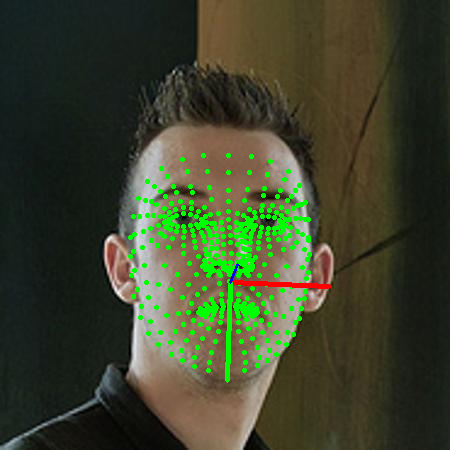

In [20]:
faceModule = mediapipe.solutions.face_mesh                                      # facial mesh extractor
with faceModule.FaceMesh(static_image_mode=True) as raw_data:                   # create a FaceMesh object for the current fileName, no video stream allowed
  image = cv2.imread('/content/AFLW2000/'+ img_name + '.jpg')                   # load image using file name into memory
  results = raw_data.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))            # generate landmarks from the loaded image

  if results.multi_face_landmarks != None:                                      # making sure image is actually a facial image not a bad sample
          
          for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                cv2.circle(
                    image,
                    (relative_x, relative_y),
                    radius=1,
                    color=(0, 255, 0),
                    thickness=2
                    )

  mat = sio.loadmat('/content/AFLW2000/' + img_name + '.mat')                   # reading the true labels and drawing the axis on the image
  pitch_true = mat["Pose_Para"][0][0]
  yaw_true = mat["Pose_Para"][0][1]
  roll_true = mat["Pose_Para"][0][2]

  cv2_imshow (draw_axis(image,pitch_true,yaw_true,roll_true,X[2],Y[2]))

### Now, let's try our **model**

##### Preprocessing...

In [21]:
faceModule = mediapipe.solutions.face_mesh                                      # facial mesh extractor
raw_data = faceModule.FaceMesh(static_image_mode=True) 
# with faceModule.FaceMesh(static_image_mode=True) as raw_data:                   # create a FaceMesh object for the current fileName, no video stream allowed
image = cv2.imread('/content/AFLW2000/'+ img_name + '.jpg')                   # load image using file name into memory
results = raw_data.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))            # generate landmarks from the loaded image
features = None
if results.multi_face_landmarks != None:                                      # making sure image is actually a facial image not a bad sample
    for face in results.multi_face_landmarks:

        X = list()                                                            # list to temporarily save horizontal landmark points
        Y = list()                                                            # list to temporarily save vertical landmark points

        for landmark in face.landmark:                                        # extracting every landmark point in the selected face data
            X.append(int(landmark.x * image.shape[1]))                        # upscaling the x landmark component to the original image size, then saving it into x landmarks vector
            Y.append(int(landmark.y * image.shape[0]))                        # upscaling the y landmark component to the original image size, then saving it into y landmarks vector
            
        X = np.array(X)                                                       # converting both lists to numpy arrays
        Y = np.array(Y)

        ref_X = X - X[2]                                                      # referencing the points to our reference point
        ref_Y = Y - Y[2]

        length = np.linalg.norm(                                              # calculating the arbitrary line length
            np.array((X[175],Y[175])) - np.array((X[10],Y[10]))
            )

        X_norm = ref_X/length                                                 # nnormalizing the points
        Y_norm = ref_Y/length

        features = np.hstack([X_norm,Y_norm]).reshape(1,-1)                   # getting ordered pair as features
  

##### **Moment of Truth**

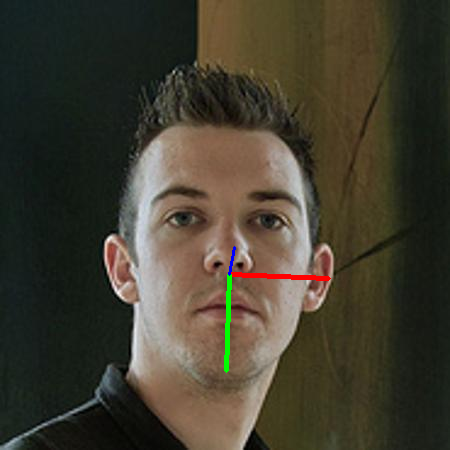

In [22]:
 # predicting the 3 angels to draw the axis on the image
pitch_prediction = moodel_xgb_pitch_best.predict(features)
yaw_prediction = moodel_xgb_yaw_best.predict(features)
roll_prediction = moodel_xgb_roll_best.predict(features)

cv2_imshow(draw_axis(image,pitch_prediction,yaw_prediction,roll_prediction,X[2],Y[2]))

**Great Success!**

# Making a use case video!

### Importing file from workspace, taking control of camera and initializaing needed variables

In [23]:
vid = cv2.VideoCapture('me.mp4')
width= int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

if (vid.isOpened()== False): 
    print("Error opening video file")

frames = list()

### Capture and detect pose directions

In [24]:
while vid.isOpened():                                                          # keep reading frames from the video file while it is still available
    val, frame = vid.read()                                                     # read a frame

    if val == True:                                                             # if read is successful, continue the task
      with faceModule.FaceMesh(static_image_mode=True) as face:
        results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:
              
            X = list()                                                          # list to temporarily save horizontal landmark points
            Y = list()                                                          # list to temporarily save vertical landmark points

            for landmark in face.landmark:                                      # extracting every landmark point in the selected face data
                X.append(int(landmark.x * image.shape[1]))                      # upscaling the x landmark component to the original image size, then saving it into x landmarks vector
                Y.append(int(landmark.y * image.shape[0]))                      # upscaling the y landmark component to the original image size, then saving it into y landmarks vector
                
            X = np.array(X)                                                     # converting both lists to numpy arrays
            Y = np.array(Y)

            ref_X = X - X[2]                                                    # referencing the points to our reference point
            ref_Y = Y - Y[2]

            length = np.linalg.norm(                                            # calculating the arbitrary line length
                np.array((X[175],Y[175])) - np.array((X[10],Y[10]))
                )

            X_norm = ref_X/length                                               # normalizing the points
            Y_norm = ref_Y/length

            features = np.hstack([X_norm,Y_norm]).reshape(1,-1)                 # getting ordered pair as features

            pred_pitch = moodel_xgb_pitch_best.predict(features)                # predicting the 3 angels to draw the axis on the image
            pred_yaw = moodel_xgb_yaw_best.predict(features)
            pred_roll = moodel_xgb_roll_best.predict(features)

            draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[2],Y[2])
            
            frames.append(frame)                                                # appending the prediction frame to the frames list
    else:
      break                                                                       # to stop the loop if no more frames

vid.release()  
# Closes all the frames
cv2.destroyAllWindows()
print("Number of Detected Frames = ",len(frames))

Number of Detected Frames =  198


### Saving New Video

In [25]:
# converting the frames to video
out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for i in range(len(frames)):
    out.write(frames[i])
out.release()

### Downloading it to machine

In [26]:
from google.colab import files
files.download('out.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>